In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
seq_length = 15

In [4]:
minute = False
hour = True

In [5]:
data = None
idx_skip = 0
if minute:
    idx_skip = int(seq_length)
    data = pd.read_csv("BTCUSDT_15m.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

elif hour:
    idx_skip = int(seq_length / 3)
    data = pd.read_csv("BTCUSDT_1h.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

else:
    idx_skip = int(seq_length / 3)
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [6]:
data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades
0,1502942400000,4261.48,4313.62,4261.32,4308.83,47.181009,2.023661e+05,171
1,1502946000000,4308.83,4328.69,4291.37,4315.32,23.234916,1.003048e+05,102
2,1502949600000,4330.29,4345.45,4309.37,4324.35,7.229691,3.128231e+04,36
3,1502953200000,4316.62,4349.99,4287.41,4349.99,4.443249,1.924106e+04,25
4,1502956800000,4333.32,4377.85,4333.32,4360.69,0.972807,4.239504e+03,28
...,...,...,...,...,...,...,...,...
50867,1686524400000,25895.79,25938.80,25819.66,25925.55,1083.956070,2.805894e+07,28875
50868,1686528000000,25925.54,26028.50,25856.84,25965.13,1363.722650,3.535156e+07,38669
50869,1686531600000,25965.13,26000.00,25891.66,25935.17,1111.029890,2.882563e+07,33125
50870,1686535200000,25935.17,25959.56,25602.11,25773.47,3157.175120,8.132780e+07,71704


In [7]:
agent_horizon = 4
crossover_horizon = 3
crossover_lag_horizon = 1

In [8]:
ma1, ma2, ma_mode = 5, 10, 'normal'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
k1, k2 = 5, 10
handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, ma_mode)
handler.data.rename({'Label': 'Crossover'}, axis=1, inplace=True)
dummies = pd.get_dummies(handler.data['Crossover'], prefix='Crossover') * 1
handler.data.drop('Crossover', axis=1, inplace=True)
handler.data = pd.concat([handler.data, dummies], axis=1)

handler.data = ma_crossover_lagging_labelling(handler.data, ma1, ma2, crossover_lag_horizon, ma_mode)
cross_lag_dummies = pd.get_dummies(handler.data[f'Crossover_Lag_{crossover_lag_horizon}'], prefix=f'Crossover_Lag_{crossover_lag_horizon}_') * 1
handler.data.drop(f'Crossover_Lag_{crossover_lag_horizon}', axis=1, inplace=True)
handler.data = pd.concat([handler.data, cross_lag_dummies], axis=1)

handler.data = triple_barrier_labelling(handler.data, upper_barrier=1.004, lower_barrier=0.996, time_limit=agent_horizon)
handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX, Indicators.OBV, Indicators.NTRADES])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.OBV, Indicators.LOG_RET, Indicators.NTRADES])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
# predict_data[dummies.columns] = handler.data[dummies.columns]
predict_data[f'Close_{ma_name}{ma1}_PERC_DIFF'], predict_data[f'Close_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'Close_{ma_name}{ma1}_PERC_DIFF'], handler.data[f'Close_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data[cross_lag_dummies.columns] = handler.data[cross_lag_dummies.columns]
predict_data.reset_index(drop=True, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_9624\1332714173.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\user\AppData\Local\Temp\ipykernel_9624\1332714173.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\user\AppData\Local\Temp\ipykernel_9624\1332714173.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [9]:
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,Crossover_-1,Crossover_0,Crossover_1,EMA5,EMA10,Crossover_Lag_1__-1,Crossover_Lag_1__0,Crossover_Lag_1__1,Label,Index,Kendall_5,Kendall_10,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,OBV,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,LOG_RET,NTrades Var
35,1503068400000,4259.40,4259.40,4200.00,4236.89,39.947717,1.692998e+05,199,4292.280,4298.430,-0.005534,-0.001780,0.013073,0.014525,0,1,0,4276.693848,4290.793017,0,1,0,1.0,36.0,-1.0,-0.155556,39.279221,0,1,0,-23.685670,1.971949,16.866577,12.537813,20.444535,-0.729126,-0.063244,0.196231,-0.689475,0.042830,-0.061125,-0.061125,0.266282,-0.005299,-0.115556
36,1503072000000,4234.54,4283.79,4234.54,4250.34,45.038824,1.918241e+05,197,4274.286,4295.518,-0.004192,-0.000677,0.005634,0.010629,0,1,0,4267.909230,4283.433534,0,1,0,-1.0,37.0,-0.8,-0.422222,41.653683,0,1,0,-25.386954,0.216532,16.667163,14.451951,19.386441,3.034805,0.060451,0.071828,-0.890194,-0.011823,-0.051754,0.152669,-5.162249,0.003169,-0.010050
37,1503075600000,4250.34,4250.34,4066.53,4193.35,62.691466,2.633399e+05,164,4246.614,4284.828,-0.006474,-0.002489,0.012702,0.021815,0,1,0,4243.056148,4267.046715,0,1,0,0.0,38.0,-0.8,-0.600000,35.346502,0,1,0,-30.976769,-4.298627,19.128914,11.963386,31.787589,-1.046959,-0.151420,0.220185,-20.852133,0.147701,0.639682,-0.172196,-1.344984,-0.013499,-0.167513
38,1503079200000,4171.17,4297.75,4117.41,4117.41,25.318654,1.052619e+05,174,4211.478,4268.296,-0.008274,-0.003858,0.022846,0.036646,0,1,0,4201.174093,4239.829176,0,1,0,0.0,39.0,-0.8,-0.822222,29.037057,1,0,0,-41.061135,-11.506393,20.133771,14.168620,26.894400,9.004179,-0.178503,0.325546,1.676760,0.052531,-0.153934,0.184332,-9.600318,-0.018276,0.060976
39,1503082800000,4086.28,4136.48,4015.70,4136.28,60.598026,2.469052e+05,218,4186.854,4251.509,-0.005847,-0.003933,0.012227,0.027858,0,1,0,4179.542727,4220.995902,0,1,0,-1.0,40.0,-0.6,-0.911111,32.272230,0,1,0,-46.988758,-13.947214,22.111425,12.752743,32.622073,-2.154173,0.111415,0.144361,0.212127,0.098226,0.212969,-0.099931,-1.239241,0.004573,0.252874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50864,1686513600000,26030.89,26206.88,26030.88,26123.68,1809.468990,4.726703e+07,45681,25987.918,25869.353,0.002874,0.001353,-0.005197,-0.009735,0,1,0,25996.708440,25916.316277,0,1,0,-1.0,50865.0,1.0,0.733333,65.967127,0,1,0,39.529506,48.665542,20.126927,31.192063,11.114995,0.002358,0.063633,1.012021,0.188440,0.116629,-0.090772,0.089822,0.227951,0.003558,0.071720
50865,1686517200000,26123.69,26139.78,25972.64,26046.37,963.479240,2.511259e+07,28898,26023.514,25894.384,0.001370,0.000968,-0.000878,-0.005835,0,1,0,26013.262293,25939.962408,0,1,0,-1.0,50866.0,0.8,0.866667,60.341107,0,1,0,48.489571,46.100486,21.330864,28.542388,13.130793,-0.001252,-0.085285,0.226668,-0.052708,0.059817,0.181358,-0.084947,-1.531213,-0.002964,-0.367396
50866,1686520800000,26046.37,26070.00,25745.03,25895.80,2097.215660,5.431792e+07,47704,26014.348,25908.964,-0.000352,0.000563,0.004578,0.000508,1,0,0,25974.108195,25931.932880,0,1,0,1.0,50868.0,0.0,0.688889,51.185124,0,1,0,42.945696,32.445288,20.196988,24.232262,21.724580,-0.002730,-0.151737,-0.114331,-0.296205,-0.053157,0.654476,-0.151008,1.179440,-0.005798,0.650772
50867,1686524400000,25895.79,25938.80,25819.66,25925.55,1083.956070,2.805894e+07,28875,26004.458,25931.186,-0.000380,0.000858,0.003044,0.000217,1,0,0,25957.922130,25930.772356,0,1,0,-1.0,50870.0,-0.4,0.466667,52.711905,0,1,0,40.486013,23.988484,19.144103,22.868803,20.502219,0.001415,0.029829,-0.057274,-0.260648,-0.052131,-0.056266,-0.056266,-1.518269,0.001148,-0.394705


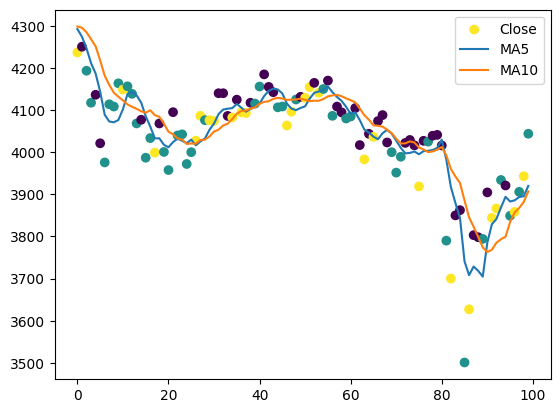

In [10]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'MA{ma1}'][0:100], label=f"MA{ma1}")
plt.plot(range(100), handler.data[f'MA{ma2}'][0:100], label=f"MA{ma2}")
plt.legend()
plt.show()

In [11]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,NTrades Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP,Crossover_Lag_1__-1,Crossover_Lag_1__0,Crossover_Lag_1__1
0,1503068400000,-0.063244,0.196231,-0.689475,0.042830,-0.061125,-0.061125,0.266282,-0.115556,0,1,0,-0.005299,1.0,-1.0,-0.155556,-0.005534,-0.001780,0.013073,0.014525,0,1,0,1,0
1,1503072000000,0.060451,0.071828,-0.890194,-0.011823,-0.051754,0.152669,-5.162249,-0.010050,0,1,0,0.003169,-1.0,-0.8,-0.422222,-0.004192,-0.000677,0.005634,0.010629,0,1,0,1,0
2,1503075600000,-0.151420,0.220185,-20.852133,0.147701,0.639682,-0.172196,-1.344984,-0.167513,0,1,0,-0.013499,0.0,-0.8,-0.600000,-0.006474,-0.002489,0.012702,0.021815,0,1,0,1,0
3,1503079200000,-0.178503,0.325546,1.676760,0.052531,-0.153934,0.184332,-9.600318,0.060976,1,0,0,-0.018276,0.0,-0.8,-0.822222,-0.008274,-0.003858,0.022846,0.036646,0,1,0,1,0
4,1503082800000,0.111415,0.144361,0.212127,0.098226,0.212969,-0.099931,-1.239241,0.252874,0,1,0,0.004573,-1.0,-0.6,-0.911111,-0.005847,-0.003933,0.012227,0.027858,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50828,1686513600000,0.063633,1.012021,0.188440,0.116629,-0.090772,0.089822,0.227951,0.071720,0,1,0,0.003558,-1.0,1.0,0.733333,0.002874,0.001353,-0.005197,-0.009735,1,0,0,1,0
50829,1686517200000,-0.085285,0.226668,-0.052708,0.059817,0.181358,-0.084947,-1.531213,-0.367396,0,1,0,-0.002964,-1.0,0.8,0.866667,0.001370,0.000968,-0.000878,-0.005835,1,0,0,1,0
50830,1686520800000,-0.151737,-0.114331,-0.296205,-0.053157,0.654476,-0.151008,1.179440,0.650772,0,1,0,-0.005798,1.0,0.0,0.688889,-0.000352,0.000563,0.004578,0.000508,1,0,0,1,0
50831,1686524400000,0.029829,-0.057274,-0.260648,-0.052131,-0.056266,-0.056266,-1.518269,-0.394705,0,1,0,0.001148,-1.0,-0.4,0.466667,-0.000380,0.000858,0.003044,0.000217,1,0,0,1,0


In [12]:
dataset = TSDataset(predict_data, seq_length)

In [13]:
train_indices = range(0, round(0.7 * len(dataset)), idx_skip)
val_indices = range(round(0.7 * len(dataset)), round(0.9 * len(dataset)), idx_skip)
test_indices = range(round(0.9 * len(dataset)), len(dataset) - seq_length)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices) # Validation set will be training set for Meta Labelling
test_set = torch.utils.data.Subset(dataset, test_indices)

In [14]:
label_distribution = (predict_data.loc[train_set.indices, 'Target'].value_counts() / predict_data.loc[train_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[train_set.indices, 'Target'].value_counts())
label_distribution

-1.0    2671
 1.0    2651
 0.0    1793
Name: Target, dtype: int64

[0.3754040758959944, 0.25200281096275473, 0.3725931131412509]

In [15]:
class_weights = [1 / p for p in label_distribution]
print(class_weights)
# class_weights = [4, 1, 4]
weights = [class_weights[torch.argmax(label)] for _, label in train_set]
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_set), replacement=True)
# train_sampler = None

[2.663796330962186, 3.9682097044060236, 2.683892870614862]


In [16]:
input_size = dataset.size
hidden_size = 500
batch_size = 32
num_layers = 1
output_size = predict_data['Target'].unique().size
lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, output_size).to(device)

In [19]:
weights = torch.Tensor(label_distribution).to(device)
train_lstm(lstm_model, train_set, val_set, 10, 0.00001,
           batch_size, num_layers, hidden_size, device, train_sampler, class_weights=None, model_name=f'agent_{seq_length}_to_{agent_horizon}', save=True)

Epoch: 1/10 -- [2453/7115 (100.0%)]	Loss: 1.0913531742822964	Accuracy: 0.368	Time taken: 35.171875	Validation Loss: 1.1006641387939453 || Validation Accuracy: 0.337
Epoch: 2/10 -- [2453/7115 (100.0%)]	Loss: 1.0920654658244864	Accuracy: 0.363	Time taken: 35.203125	Validation Loss: 1.0933021306991577 || Validation Accuracy: 0.356
Epoch: 3/10 -- [2453/7115 (100.0%)]	Loss: 1.0919707249098294	Accuracy: 0.358	Time taken: 35.734375	Validation Loss: 1.0937013626098633 || Validation Accuracy: 0.364
Epoch: 4/10 -- [2453/7115 (100.0%)]	Loss: 1.091949144286425	Accuracy: 0.366	Time taken: 36.390625	Validation Loss: 1.0912548303604126 || Validation Accuracy: 0.365
Epoch: 5/10 -- [2453/7115 (100.0%)]	Loss: 1.0895013467078787	Accuracy: 0.372	Time taken: 36.640625	Validation Loss: 1.0977739095687866 || Validation Accuracy: 0.367
Epoch: 6/10 -- [2453/7115 (100.0%)]	Loss: 1.0916859285713847	Accuracy: 0.370	Time taken: 36.453125	Validation Loss: 1.0974671840667725 || Validation Accuracy: 0.367
Epoch: 7/10

([1.0913531742822964,
  1.0920654658244864,
  1.0919707249098294,
  1.091949144286425,
  1.0895013467078787,
  1.0916859285713847,
  1.0901081460473783,
  1.0892766505613456,
  1.0882018184448037,
  1.0905064189380596],
 [0.3683766690091356,
  0.363035839775123,
  0.3583977512297962,
  0.3657062543921293,
  0.37231201686577653,
  0.3702037947997189,
  0.37554462403373157,
  0.3735769501054111,
  0.3734364019676739,
  0.37160927617709066],
 [tensor(1.1007),
  tensor(1.0933),
  tensor(1.0937),
  tensor(1.0913),
  tensor(1.0978),
  tensor(1.0975),
  tensor(1.0917),
  tensor(1.0901),
  tensor(1.0917),
  tensor(1.0924)],
 [0.3369404820462371,
  0.3561239547466798,
  0.3635022134776193,
  0.36546974913920316,
  0.367437284800787,
  0.367437284800787,
  0.367437284800787,
  0.38957206099360553,
  0.3694048204623709,
  0.35661583866207575],
 array([[348., 246., 290.],
        [104., 150., 115.],
        [272., 214., 294.]]),
 0.38957206099360553)

In [20]:
eval_lstm(lstm_model, test_set, 64, num_layers, hidden_size, device)

Accuracy : 0.3295835800276298 || Loss : 1.105565071105957
Confusion matrix : 
[[ 300.  594. 1035.]
 [ 168.  310.  785.]
 [ 265.  550. 1060.]]


(tensor([[0.2927, 0.3255, 0.3818],
         [0.2932, 0.3090, 0.3978],
         [0.3291, 0.2427, 0.4282],
         ...,
         [0.3427, 0.2314, 0.4258],
         [0.3264, 0.2515, 0.4221],
         [0.2944, 0.3299, 0.3757]], grad_fn=<CatBackward0>),
 tensor([[0., 0., 1.],
         [0., 1., 0.],
         [0., 0., 1.],
         ...,
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]))